In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

In [317]:
df_gld = pd.read_csv(r"D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv")
print(df_gld.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [318]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df_gld['Date'] = pd.to_datetime(df_gld['Date'])
df_gld = fill_missing_values_date(df_gld, 'Date', 'GLD')
df_gld.set_index('Date', inplace=True)
data = df_gld['GLD'].values
data = np.reshape(data, (-1,1))

In [319]:
time = df_gld.index
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[0.12967974]
 [0.13587574]
 [0.13203593]
 ...
 [0.47552142]
 [0.46702942]
 [0.45853741]]


In [320]:
split_ratio = 0.8
split_idx = int(len(scaled_data) * split_ratio)
data_train, data_test = scaled_data[:split_idx], scaled_data[split_idx:]

In [321]:
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Chia dữ liệu thành chuỗi thời gian với mỗi bước là 5 ngày
time_step = 5
X_train, y_train = create_dataset(data_train, time_step)
X_test, y_test = create_dataset(data_test, time_step)
X_train, y_train = np.array(X_train), np.array(y_train)

In [322]:
epochs= 50

# build the model
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='sigmoid'),
    Dense(1)
])
# compile the model
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [323]:
batch_size = 64

lr_model_history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 0.1384
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0347
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0182
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.0079
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2311e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9541e-04
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8512e-04
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2783e-04
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2599e-04 
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1696e-04 
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2572e-04
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0311e-04
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1783e-04
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 

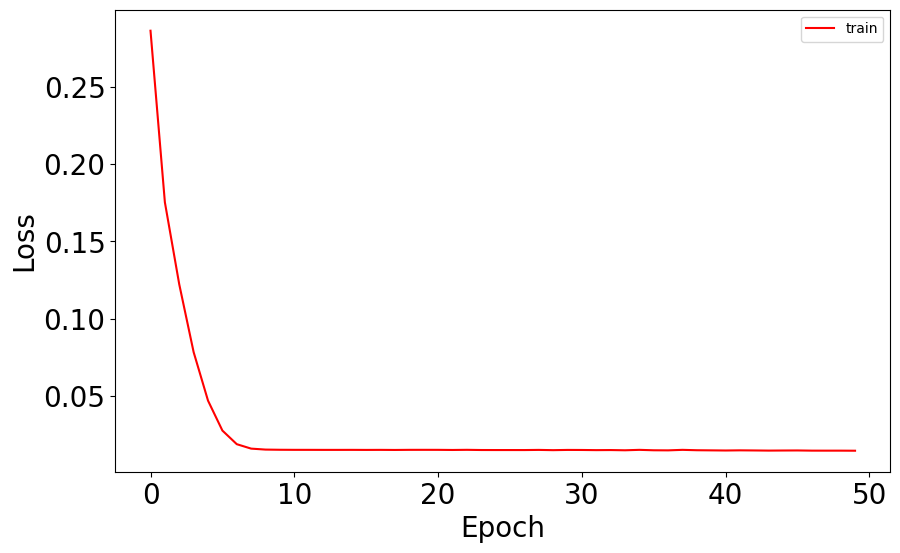

In [324]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)


In [325]:
model.fit(X_train, y_train, batch_size = 64, epochs = 10)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1291e-04
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 2.2871e-04
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 2.1148e-04
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0780e-04
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 2.0827e-04
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 2.1779e-04
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2816e-04 
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2.1046e-04
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 2.0080e-04
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2.4054e-04


In [326]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = np.reshape(predicted_prices, -1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [327]:
acctually_prices = data[split_idx+time_step+1:]
acctually_prices = np.reshape(acctually_prices, -1)

In [328]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, predicted_prices)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, predicted_prices)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, predicted_prices)
print(f"MAPE: {mape}")

MSE: 1.6380957769576405
MAE: 0.9982133364395034
MAPE: 0.8241099365693474


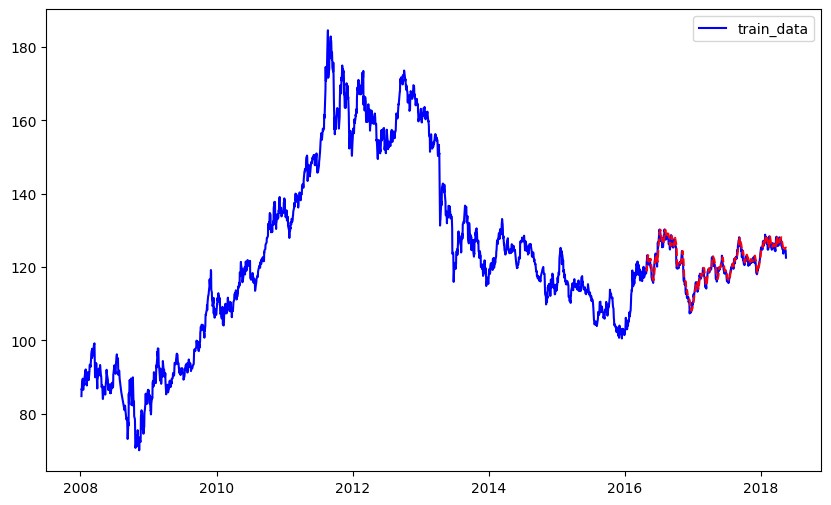

In [329]:
plt.figure(figsize=(10, 6))
plt.plot(time[time_step:] , data[time_step:],label = "train_data", color = "b")
plt.plot(time[time_step+split_idx+1:], predicted_prices, color = "red", linestyle = '--')
plt.legend()
plt.show()